In [192]:
import numpy as np # linear algebra
import pandas as pd
import os
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Modèle 1: LSTM

In [193]:
data=pd.read_fwf("SPX.txt")
data.columns = ['Date',"Prix"]

data["Prix"]=data.Prix.astype(float)
data["Date"]=pd.to_datetime(data["Date"])
data.describe()

,Prix
count,1291.000000
mean,1425.181317
std,584.076396
min,464.780000
25%,1072.500000
50%,1282.800000
75%,1665.450000
max,3025.800000


In [194]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

<ipython-input-194-fa1560e9013b>:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Date,Prix
0,1995-01-13,465.97
1,1995-01-20,464.78
2,1995-01-27,470.39
3,1995-03-02,478.64
4,1995-10-02,481.46


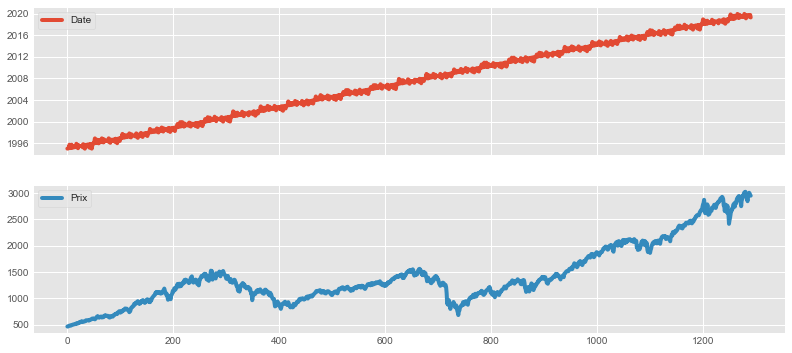

In [195]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()

           Date     Prix
0    1995-01-13   465.97
1    1995-01-20   464.78
2    1995-01-27   470.39
3    1995-03-02   478.64
4    1995-10-02   481.46
...         ...      ...
1286 2019-06-09  2978.70
1287 2019-09-13  3007.30
1288 2019-09-20  2992.00
1289 2019-09-27  2961.70
1290 2019-04-10  2952.00

[1291 rows x 2 columns]


,count,mean,std,min,25%,50%,75%,max
Prix,1291.0,1425.181317,584.076396,464.78,1072.5,1282.8,1665.45,3025.8


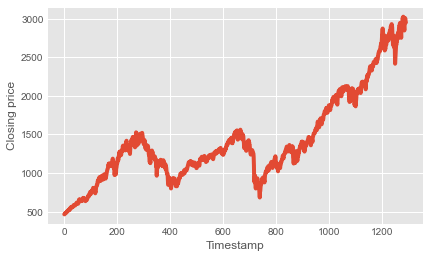

In [196]:
plt.plot(data['Prix'], label="Close Prix")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

Les données ont été analysées mais elles doivent être converties en données de forme [100,1] pour faciliter l'entraînement de CNN... Sinon, il ne sélectionnera pas les fonctionnalités nécessaires et le modèle échouera

In [197]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,1]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 1] - first) / first)
    temp2.append((df.iloc[i + window_size, 1] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

In [198]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

951
238


In [200]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
24/24 [==============================] - 14s 130ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1628 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0954
Epoch 2/40
24/24 [==============================] - 1s 23ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0925 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0774
Epoch 3/40
24/24 [==============================] - 1s 22ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0759 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0688
Epoch 4/40
24/24 [==============================] - 1s 22ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0701 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0619
Epoch 5/40
24/24 [==============================] - 1s 22ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0694 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0591
Epoch 6/40
24/24 [==============================] - 1s 22ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0642 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0548
Epoch 7/40
24/24 [==

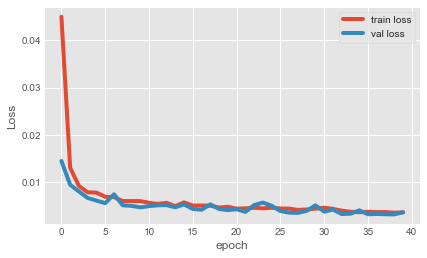

In [201]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

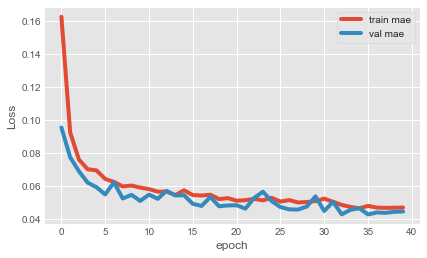

In [202]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [203]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 98, 64)        256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 49, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 47, 128)       24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 23, 128)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 21, 64)       

In [204]:
model.evaluate(test_X, test_Y)

8/8 [==============================] - 0s 7ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0444


[0.003693611826747656, 0.003693611826747656, 0.044365935027599335]

In [205]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)


var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.951824
R2 Score: 0.951824
Max Error: 0.229728


# Modèle 2 : GRU

In [206]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [207]:
data=pd.read_excel("SPX_1.xlsx")
#data.columns = ['Date',"Prix"]

data["Prix"]=data.Prix.astype(float)

data["Date"]=pd.to_datetime(data.Date)
data.head()

,Date,Prix
0,1995-01-13,465.97
1,1995-01-20,464.78
2,1995-01-27,470.39
3,1995-03-02,478.64
4,1995-10-02,481.46


In [208]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  1995-01-13 00:00:00
Ending date:  2019-04-10 00:00:00
Duration:  8853 days 00:00:00


In [209]:
monthvise= data.groupby(data['Date'].dt.strftime('%B'))["Prix"].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Date
January      1399.978716
February     1406.431386
March        1411.110991
April        1437.421038
May          1428.451182
June         1446.792130
July         1441.809909
August       1449.962545
September    1465.640463
October      1384.060093
November     1400.277282
December     1427.514537
Name: Prix, dtype: float64

In [210]:
closedf = data[['Date','Prix']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1291, 2)


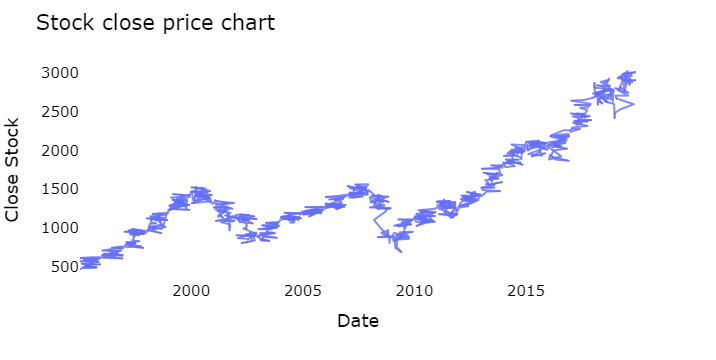

In [211]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Prix,labels={'Date':'Date','Prix':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [212]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1291, 1)


In [213]:
#Prepare Data for train and test
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (774, 1)
test_data:  (517, 1)


In [214]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [215]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (758, 15)
y_train:  (758,)
X_test:  (501, 15)
y_test (501,)


In [216]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (758, 15, 1)
X_test:  (501, 15, 1)


In [217]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [218]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [219]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=40,batch_size=32,verbose=1)

Epoch 1/40
24/24 [==============================] - 12s 105ms/step - loss: 0.0170 - val_loss: 0.0710
Epoch 2/40
24/24 [==============================] - 1s 36ms/step - loss: 0.0035 - val_loss: 0.0192
Epoch 3/40
24/24 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 4/40
24/24 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 9.8072e-04
Epoch 5/40
24/24 [==============================] - 1s 34ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/40
24/24 [==============================] - 1s 33ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/40
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/40
24/24 [==============================] - 1s 33ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/40
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 7.7382e-04
Epoch 10/40
24/24 [==============================] - 1s 34ms/step - loss: 8.9884e-04 - val_loss: 0.

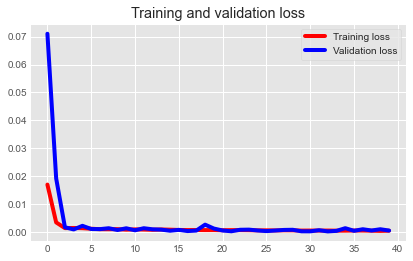

<Figure size 432x288 with 0 Axes>

In [220]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()


In [221]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((758, 1), (501, 1))

In [222]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [232]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("Test data R²: ", r2_score(original_ytest,test_predict))
print("Test Max ERROR: ", max_error(original_ytest,test_predict))

Train data RMSE:  37.77176752085904
Train data MSE:  1426.706421649822
Train data MAE:  28.67847062324786
-------------------------------------------------------------------------------------
Test data RMSE:  61.6270197068758
Test data MSE:  3797.8895579516584
Test data MAE:  46.425798549385554
Test data R²:  0.9879979093132077
Test Max ERROR:  204.73627929687473


In [224]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9848316554576796
Test data explained variance regression score: 0.990724458413295


### Score R2 pour la régression
 Le R au carré (R2) est une mesure statistique qui représente la proportion de la variance d'une variable dépendante expliquée par une ou plusieurs variables indépendantes dans un modèle de régression.

In [225]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9785113479723488
Test data R2 score: 0.9879979093132077


# Modèle 3:  Regression Lineare

In [226]:
# Regression Lineare

data = data.reset_index()
x = np.array(data.index).reshape(-1, 1)
y = data['Prix']

In [227]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.1,random_state = 0)
LR = LinearRegression().fit(x_train,y_train)
LR.score(x_test,y_test)
predictions = LR.predict(x)

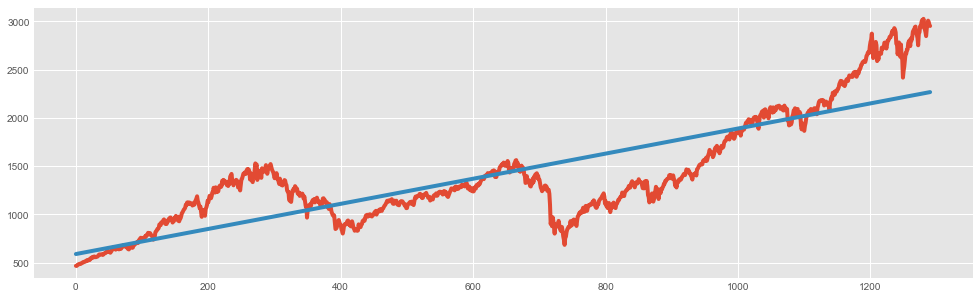

In [228]:
plt.figure(figsize=(15,5))
plt.plot(data['Prix'])
plt.plot(data.index, predictions)

In [231]:
from sklearn.metrics import mean_squared_error


print('R²: ', LR.score(x_test,y_test))
print('MSE:  ', mean_squared_error(x_test,y_test) )
print("MAX ERROR:  ",max_error(x_test,y_test))


R²:  0.7086703527440819
MSE:   695111.333136923
MAX ERROR:   1720.3000000000002


# Tableau Final des résultat 


|                             | Métrique 1(R²)     | Métrique 2(MSE)  | Métrique 3(MAX ERROR) |   |   |   |   |   |   |
|-----------------------------|--------------------|------------------|-----------------------|---|---|---|---|---|---|
| Modèle 1  (LSTM)            | 0.951824           | 4656.115         | 56.20                 |   |   |   |   |   |   |
| Modèle 2(GRU)               | 0.987997909        | 1426.7064        | 204.736279            |   |   |   |   |   |   |
| Modèle 3(Linear Regression) | 0.7086703527440819 | 695111.333136923 | 1720.300              |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
|                             |                    |                  |                       |   |   |   |   |   |   |
